# Power spectra of mock cluster observations

## Last edited by Charles Romero 05 September 2025

Now that we've considered power spectra in an image which is described by some power spectrum, let's consider the actual kind of image (but idealized, of course) that we might encounter.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import gcfluct.gc.selfsimilar_gc as ssgc
import gcfluct.spectra.spectra2d as spectra
import gcfluct.spectra.gc_spec_deproj as deproj
import gcfluct.utils.image_filtering as imf
import gcfluct.utils.mock_obs as mo
import astropy.units as u

### Pick a cluster

Defined by self-similar criteria, i.e. solely z and $M_{500}$.

In [2]:
z = 0.4
m500 = 5e14 * u.M_sun 

In [3]:
gc_model = ssgc.SS_Model(z,m500)

In [4]:
#d_ang = ssgc.get_d_ang(z).to("kpc").value
kpc_per_arcsecond = gc_model.d_ang.to("kpc").value / (3600 * 180 / np.pi)
print("kpc per arcsecond: ",kpc_per_arcsecond)

kpc per arcsecond:  5.37273628890832


In [5]:
gc_model.set_xr_USBP()

## Prepare to make a mock cluster image.

We have a radial surface brightness profile in hand, but now we want to add fluctuations to that surface brightness image. To do that, we'll want to make a map with a given power spectrum. In particular, let's choose a plausible (idealized, as always) power spectrum for density (well, emissivity) fluctuations.

In [6]:
# Define a turbulent (3D) power spectrum. 
# I'm ignoring a dissipative scale; the default will put it at very small scales
# I'll also leave the eta_c and eta_d parameters as their defaults.

kc = 1e-3         # Assume this is in [pixsize]^(-1) -- so kpc^-1 in our case.
slope = -3.7        # Power goes as k**slope
p0 = 1e-4         # Arbitrary units at the moment
no_warn = True    # Ignore some warnings (in regards to pixels for image creation) for now.
ps2img = spectra.ImagesFromPS(slope=slope,kc=kc,p0=p0,no_warn=no_warn)

### Let's embark on making images
1. We'll want to define some basic image properties (size, pixel size, etc.)

Let's mimic an XMM image. 

ESAS typically generates images with 2.5 arcecond pixels (for EPIC cameras).
For a specific cluster, or rather, a specific redshift, we can consider the pixel size
either in arcseconds or in kilparsecs. Given that we've defined our power spectrum in
(inverse) kpc, __we need to specify the pixsize in kpc__.

#### A note on field of view (FOV):
XMM's EPIC cameras have a ~30' FOV. So the images go out to 15' radially.
We could try to replicate that in earnest, but we could also trim the image down to 2*R500, radially.

In [7]:
pix_arcsec = 2.5 # 
pixsize = pix_arcsec*kpc_per_arcsecond    # in kpc
# We set no_warn earlier because the class strongly prefers units to be set.
# It's still "optional" insofar as there are use cases where you don't need to set
# the units
pixunits = u.kpc 
n_r500 = 2
npix = int(np.round(gc_model.arcminutes500*2*n_r500*60/pix_arcsec))   
ps2img.set_image_size(npix,pixsize,pixunits=pixunits)
# Same number as in x -- keep things simple.

#### Continuing on making images:

2. Let's generate an image with the input power spectrum and
3. Feed that into gc_model, which will enable it to generate a model image for the cluster.

In [8]:
image = ps2img.generate_realization()
gc_model.set_ss_maps(imagefromps=ps2img) # Let gc_model know the grid used for producing maps.

You might wonder how I've gone from a 3D power spectrum to a 2D image of it.
Well, I haven't -- yet.

4. (Approximately) project the 3D power spectrum image to its 2D counterpart.

We'll do the approximate way to projecting below.

In [9]:
image_is_sz = False # We are modeling (simulating) an X-ray image, not SZ here.
gc_deproj = deproj.SpecDeproj(gc_model,spec_model=ps2img,sz = image_is_sz) 
n_map = gc_deproj.return_integ_nmap(use_obs_spec=False) # Gives factors to translate between P_2D and P_3D

Now we have all the pieces to start making a proper model image. In this case, the model images immediately at access that we are considering are X-ray surface brightness images (as count rate images).

5. Make count rate images.

In [10]:
ds_s = np.sqrt(n_map.value) * image     # (Model) Normalized residual.
ds = ds_s * gc_model.xrsb_map      # (Model) Residual image in cnts/s/arcmin**2
s_cluster = ds + gc_model.xrsb_map # (Model) image in cnts/s/arcmin**2

To continue, we need to actually generate count maps -- these are the fundamental X-ray data products.

6. Make count images

We'll need to adopt some exposure for this. We'll adopt 50 ks below.

In [11]:
ksec = 1e6 # kiloseconds; 1e5 = a tenth of a Gs = 3 years.
exposure_map = mo.mock_XMM_exposure(ps2img,ksec,rot=30,incChipGaps=True) # in seconds

Oh, but then we also need to be realistic and add background counts. These can come from particles (a significant source, which ESAS estimates and generates a _bkg image) and other sources. Without separating the exact origin of a remaining background, I'll call  it the "cosmic" background (this isn't exactly correct). From experience, this tends to be of order 1e-3 counts/s/arcmin**2 if not fairly close to that value.

__NB__ I will not try to simulate point sources here, *but* they are also another issue to consider. At the bright end, ESAS (especially via cheese) will identify point sources such that they can be masked. At the faint end, point sources may not be identified and can contribute to contamination. There are ways to account for this (cf Romero et al. 2023).

In [12]:
s_particle_bkg = 1e-3                  # This is a typical uniform, quiescent particle X-ray background. Soft protons and SWCX usually are sub-dominant.
s_cosmic_bkg = 1e-3                    # The cosmic X-ray background
s_bkg = s_particle_bkg + s_cosmic_bkg  # Total background rate

In [13]:
s_tot = s_cluster + s_bkg  # Assume that we can account for all photons in this manner
Counts_Total = s_tot * exposure_map * (pix_arcsec/60)**2
Noise_Counts = (gc_model.xrsb_map + s_bkg) * exposure_map * (pix_arcsec/60)**2

In [14]:
rng = np.random.default_rng()
SyntheticImage = rng.poisson(lam=Counts_Total)

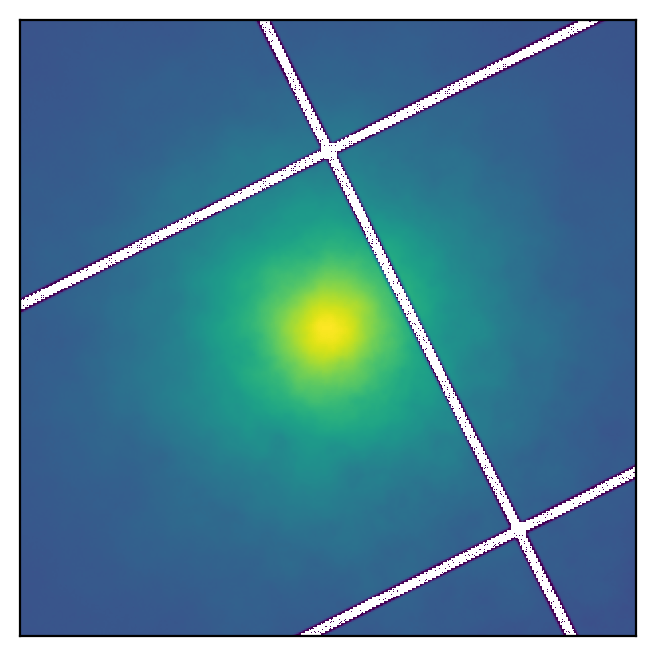

In [15]:
CntFig = plt.figure(1,figsize=(4,4),dpi=200)
CntAx = CntFig.add_subplot(111)
CntAx.imshow(SyntheticImage,norm="log")
#xlims = CntAx.get_xlim()
#ylims = CntAx.get_ylim()
#CntAx.set_xlim(xlims)
#CntAx.set_ylim(ylims)
    
CntAx.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

## Exercise for the reader

Now that you've seen the construction of this image and how to calculate the power spectrum, you should try to compute the power spectrum of the fluctuations from only `SyntheticImage` and `exposure_map`. In principle, ESAS (the XMM processing software) will also produce a background map due to particles. So, rather than a uniform map (taken as a scalar above), `S_particle_bkg` would be a map produced by ESAS (but in counts, with non-negative float values).

### General steps:
1. Fit a surface brightness profile to the data
2. Calculate a $\delta S / S$ map
3. Calculate "the" power spectrum 
   * Within what region(s)?
5. Deproject from the image PS ($P_{2D}$) to the 3-d power spectrum ($P_{3D}$)

In [16]:
model_cluster_counts = gc_model.xrsb_map * exposure_map * (pix_arcsec/60)**2
# Counts_Total

In [17]:
def create_mask(exposure,sigma=2,showImage=False):
    expo_ggm = ndi.gaussian_gradient_magnitude(exposure,sigma)
    expo_smo = ndi.gaussian_filter(exposure,sigma)
    expo_rat = exposure / expo_smo
    tomask = (expo_ggm > 0.5*np.max(expo_ggm)) + (expo_rat > 1.05) + (exposure < 0.5*np.median(exposure))
    mymask = np.ones(exposure.shape)
    mymask[tomask] = 0
    if showImage:
        MaskFig = plt.figure(2,figsize=(4,4),dpi=200)
        MaskFig.clf()
        MaskAx = MaskFig.add_subplot(111)
        MaskAx.imshow(mymask,vmin=0,vmax=1)   
        MaskAx.tick_params(top=False, bottom=False, left=False, right=False,
                        labelleft=False, labelbottom=False)

    return mymask

def alla_Eckert(img2ps_obj,cnts,model,exposure,pixArea,addMask=None,RMS=False,useModel=False,msk_bin=1):

    mask_by_bin = img2ps_obj.mask_by_bin
    myinds = (mask_by_bin == msk_bin)
    mymask = np.zeros(model.shape)
    mymask[myinds] = 1
    if addMask is None:
        if useModel:
            mean_sb = np.sqrt(np.mean(model**2)) if RMS else np.mean(model)
        else:
            mean_sb = np.sqrt(np.mean(cnts**2)) if RMS else np.mean(cnts)
        expo_sq = np.mean(exposure**2)
    else:
        total_mask = addMask*mymask
        if useModel:
            if RMS:
                mean_sb = np.sqrt(np.sum( (model*total_mask)**2) /np.sum(total_mask**2)) 
            else:
                mean_sb = np.sum(model*total_mask) / np.sum(total_mask)
        else:
            if RMS:
                mean_sb = np.sqrt(np.sum( (cnts*total_mask)**2) /np.sum(total_mask**2)) 
            else:
                mean_sb = np.sum(cnts*total_mask) / np.sum(total_mask)
                
        expo_sq = np.sum( (exposure*total_mask)**2 ) / np.sum(total_mask)

    mean_sb *= pixArea
    Rescaled = cnts / (mean_sb * np.sqrt(expo_sq))

    img2ps_obj.update_img(Rescaled)
    img2ps_obj.ps_via_a12_2d()

    return mean_sb, expo_sq

In [18]:
myMask = create_mask(exposure_map,showImage=False) # Finds chip gaps...roughly
one_annulus = [5*gc_model.r500.value/100, gc_model.r500.value]  # Will take an annulus (circle) with 0 <= r < R500.
annuli = np.array([5,19,46,100])*gc_model.r500.value/100.0  # Will take an annulus (circle) with 0 <= r < R500.

r500_mask = np.ones(ps2img.rmat.shape)
omit = (ps2img.rmat > gc_model.r500.value)  # r500 will is in kpc already.
r500_mask[omit] = 0

FullMask = r500_mask*myMask

n_avg = np.sum(n_map.value * FullMask) / np.sum(FullMask)

In [19]:
Eckert_case1 = spectra.PSfromImages(SyntheticImage, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = FullMask)
Eckert_case1.set_annular_mask_by_bin(one_annulus)
Eckert_case1.set_wave_numbers()  # Omit option inputs -> use defaults

Eckert_case2 = spectra.PSfromImages(SyntheticImage, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = FullMask)
Eckert_case2.set_annular_mask_by_bin(annuli)
Eckert_case2.set_wave_numbers()  # Omit option inputs -> use defaults

Eckert_case1_N = spectra.PSfromImages(SyntheticImage, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = FullMask)
Eckert_case1_N.set_annular_mask_by_bin(one_annulus)
Eckert_case1_N.set_wave_numbers()  # Omit option inputs -> use defaults

Eckert_case2_N = spectra.PSfromImages(SyntheticImage, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = FullMask)
Eckert_case2_N.set_annular_mask_by_bin(annuli)
Eckert_case2_N.set_wave_numbers()  # Omit option inputs -> use defaults

Romero_case1 = spectra.PSfromImages(SyntheticImage, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = FullMask)
Romero_case1.set_annular_mask_by_bin(annuli)
Romero_case1.set_wave_numbers()  # Omit option inputs -> use defaults
Romero_noise = spectra.PSfromImages(SyntheticImage, pixsize=pixsize, pixunits=pixunits, intrinsic_mask = FullMask)
Romero_noise.set_annular_mask_by_bin(annuli)
Romero_noise.set_wave_numbers()  # Omit option inputs -> use defaults

fft_obj = spectra.PSfromImages(image * np.sqrt(n_avg), pixsize=pixsize, pixunits=pixunits, intrinsic_mask = None)
fft_obj.ps_via_fft_2d()

In [20]:
nIters = 5
pixArea = (pix_arcsec/60)**2
redoAll = True
useSN = True

for i in range(nIters):

    if redoAll:
        image = ps2img.generate_realization()
        ds_s = np.sqrt(n_map.value) * image     # (Model) Normalized residual.
        ds = ds_s * gc_model.xrsb_map      # (Model) Residual image in cnts/s/arcmin**2
        s_cluster = ds + gc_model.xrsb_map # (Model) image in cnts/s/arcmin**2
        s_tot = s_cluster + s_bkg  # Assume that we can account for all photons in this manner
        Counts_Total = s_tot * exposure_map * (pix_arcsec/60)**2
    SyntheticImage = rng.poisson(lam=Counts_Total)
    SyntheticNoise = rng.poisson(lam=Noise_Counts)
    Cnts4Noise = SyntheticNoise if useSN else SyntheticImage

    # Case 1: Take Eckert+ 2017 in the most literal sense.
    residual = SyntheticImage - model_cluster_counts
    u_s1, sumE1 = alla_Eckert(Eckert_case1, residual,gc_model.xrsb_map, exposure_map, pixArea, addMask=FullMask,RMS=False,useModel=True)
    noise_case1 = np.sum(Cnts4Noise*FullMask) / (u_s1**2 * sumE1) * pixsize**2 / np.sum(FullMask)
    u_s1N, sumE1N = alla_Eckert(Eckert_case1_N, SyntheticNoise,gc_model.xrsb_map + s_cosmic_bkg, exposure_map, pixArea, addMask=FullMask,RMS=False,useModel=True)

    # Case 2: Assume Eckert+ 2017 wants to calculate PS on the *residual* image.
    u_s2, sumE2 = alla_Eckert(Eckert_case2,residual,gc_model.xrsb_map, exposure_map, pixArea, addMask=FullMask,RMS=False,useModel=True)
    noise_case2 = np.sum(Cnts4Noise*FullMask) / (u_s2**2 * sumE2) * pixsize**2 / np.sum(FullMask)
    u_s2N, sumE2N = alla_Eckert(Eckert_case2_N, SyntheticNoise - model_cluster_counts,gc_model.xrsb_map, exposure_map, pixArea, addMask=FullMask,RMS=False,useModel=True)
    
    # Case 6: How I do it.
    norm_resid = residual / exposure_map / (pix_arcsec/60)**2 / gc_model.xrsb_map # cnt rates...
    badind = np.isnan(norm_resid)
    norm_resid[badind] = 0.0

    Romero_case1.update_img(norm_resid)
    Romero_case1.ps_via_a12_2d()
    resid_noise = (SyntheticNoise / exposure_map / (pix_arcsec/60)**2) - gc_model.xrsb_map 
    norm_noise = resid_noise / gc_model.xrsb_map 
    bnnind = np.isnan(norm_noise)
    norm_noise[bnnind] = 0.0
    Romero_noise.update_img(norm_noise)
    Romero_noise.ps_via_a12_2d()
    
    if i == 0:
        #pk_case1 = Eckert_case1.a12_pk - np.ones(Eckert_case1.a12_pk.shape)*noise_case1
        #pk_case2 = Eckert_case2.a12_pk - np.ones(Eckert_case2.a12_pk.shape)*noise_case2
        #pk_case3 = Eckert_case3.a12_pk - np.ones(Eckert_case3.a12_pk.shape)*noise_case3
        #pk_case4 = Eckert_case4.a12_pk - np.ones(Eckert_case4.a12_pk.shape)*noise_case4
        #pk_case5 = Eckert_case5.a12_pk - np.ones(Eckert_case5.a12_pk.shape)*noise_case5

        pk_case1 = Eckert_case1.a12_pk - Eckert_case1_N.a12_pk
        pk_case2 = Eckert_case2.a12_pk - Eckert_case2_N.a12_pk
        #print(pk_case2.shape)
        
        pk_case6 = Romero_case1.a12_pk - Romero_noise.a12_pk
        pk_case1 = np.expand_dims(pk_case1,axis=-2)
        pk_case2 = np.expand_dims(pk_case2,axis=-2)
    else:
        pk_case1_tmp = Eckert_case1.a12_pk - Eckert_case1_N.a12_pk
        pk_case2_tmp = Eckert_case2.a12_pk - Eckert_case2_N.a12_pk

        pk_case6_tmp = Romero_case1.a12_pk - Romero_noise.a12_pk
        pk_case1_tmp = np.expand_dims(pk_case1_tmp,axis=-2)
        pk_case2_tmp = np.expand_dims(pk_case2_tmp,axis=-2)

        pk_case1 = np.hstack([pk_case1, pk_case1_tmp])
        #print(pk_case2.shape)
        pk_case2 = np.hstack([pk_case2, pk_case2_tmp])

/tmp/ipykernel_162747/2730420075.py:31: RuntimeWarning: invalid value encountered in divide
  norm_resid = residual / exposure_map / (pix_arcsec/60)**2 / gc_model.xrsb_map # cnt rates...
/tmp/ipykernel_162747/2730420075.py:37: RuntimeWarning: invalid value encountered in divide
  resid_noise = (SyntheticNoise / exposure_map / (pix_arcsec/60)**2) - gc_model.xrsb_map


In [21]:
pk_case1_rms = np.std(pk_case1, axis=1)
pk_case2_rms = np.std(pk_case2, axis=1)

pk_case1_mean = np.mean(pk_case1, axis=1)
pk_case2_mean = np.mean(pk_case2, axis=1)

In [22]:
print(pk_case1.shape,pk_case1_rms.shape, pk_case2.shape, pk_case2_mean.shape)

(6, 5, 1) (6, 1) (6, 5, 3) (6, 3)


In [23]:
def plot_amp_spec(ax, kvals, ymean, yrms, label=None, prnt = False, offsets=True, labels=None):

    for ri,(pk_ev,pk_unc) in enumerate(zip(ymean.T,yrms.T)):
        if prnt:
            print(pk_ev)
            print("==========================================================")
        amp_spec = np.sqrt( pk_ev * 2 * np.pi * kvals**2)
        amp_unc = np.sqrt( pk_unc * 2 * np.pi * kvals**2) / 2
        binstr = "; bin {:d}".format(ri+1)
        if offsets:
            myoff = rng.normal(loc=1,scale=0.03)
        else:
            myoff = 1.0
        mylabel = label+binstr if labels is None else labels[ri]
        ax.errorbar(myoff*kvals, amp_spec, yerr=amp_unc, label=mylabel)

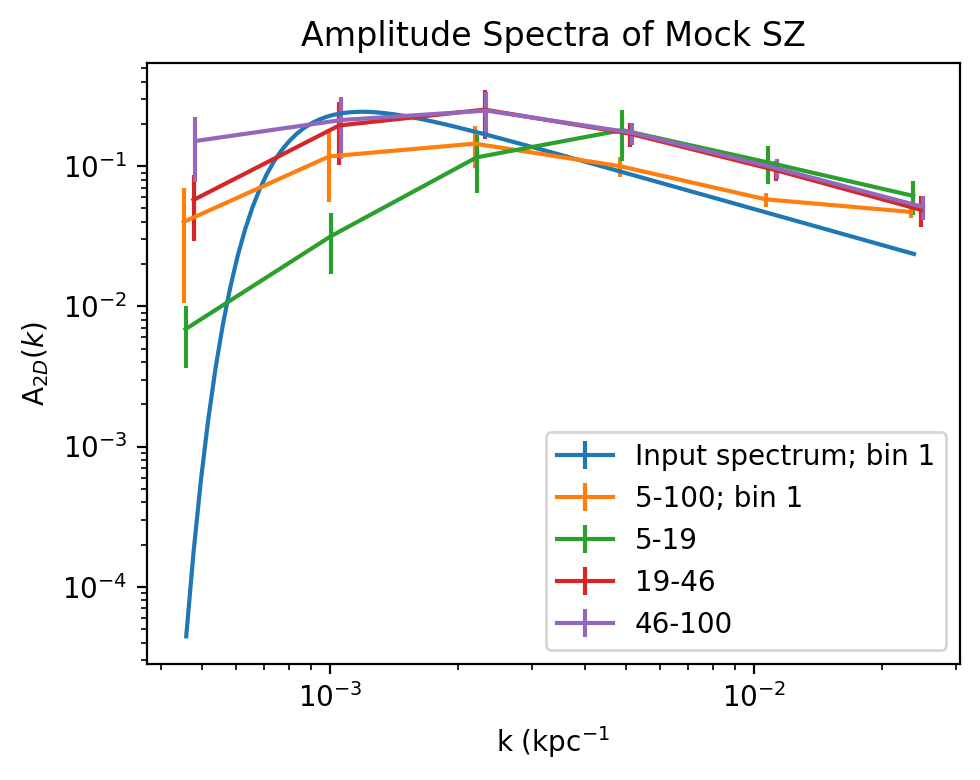

In [24]:
myfig = plt.figure(2,figsize=(5,4),dpi=200)
myfig.clf()
myax = myfig.add_subplot(111)

TheoryKs = np.logspace(np.log10(np.min(Eckert_case1.a12_kn)),np.log10(np.max(Eckert_case1.a12_kn)),100)
pk_model = np.expand_dims(ps2img.get_parameterized_ps(TheoryKs) * n_avg, axis=-1)
#print(pk_model.shape)
#import pdb;pdb.set_trace()
pk_model_rms = pk_model/1e20
plot_amp_spec(myax, TheoryKs, pk_model, pk_model_rms, label ='Input spectrum', prnt=False)
#plot_amp_spec(myax, fft_obj.fft_kb, np.expand_dims(fft_obj.fft_pk,axis=-1), 
#              np.expand_dims(fft_obj.fft_pk,axis=-1)/1e6, label ='Input spectrum, realization', prnt=False)
plot_amp_spec(myax, Eckert_case1.a12_kn, pk_case1_mean, pk_case1_rms, label ='5-100', prnt=False)
labels = ['5-19','19-46','46-100']
plot_amp_spec(myax, Eckert_case1.a12_kn, pk_case2_mean, pk_case2_rms, label ='5-100', prnt=False, labels=labels)
#for ai in range(3):
#    plot_amp_spec(myax, Eckert_case1.a12_kn, pk_case2_mean[:,ai], pk_case2_rms[:,ai], 
#                  label =labels[ai], prnt=False)

myax.set_xlabel(r"k (kpc$^{-1}$")
myax.set_ylabel(r"A$_{2D}(k)$")
myax.legend()
myax.set_xscale("log")
myax.set_yscale("log")
myax.set_title("Amplitude Spectra of Mock SZ")
myfig.tight_layout()
outdir = "/home/data/Synthetic/gcfluct/Testing_November/"
myfig.savefig(outdir+"AmplitudeSpectra_MaskBias_05Nov2025.png")

In [25]:
print( (2.5e5)**2 )

62500000000.0
